# Libraries

In [1]:
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load IPUMS data

In [3]:
ipums_labels = pd.read_stata( 'usa_00004.dta', iterator = True).variable_labels()
display(ipums_labels)

{'year': 'census year',
 'sample': 'ipums sample identifier',
 'serial': 'household serial number',
 'cbserial': 'original census bureau household serial number',
 'hhwt': 'household weight',
 'cluster': 'household cluster for variance estimation',
 'statefip': 'state (fips code)',
 'puma': 'public use microdata area',
 'strata': 'household strata for variance estimation',
 'gq': 'group quarters status',
 'pernum': 'person number in sample unit',
 'perwt': 'person weight',
 'famsize': 'number of own family members in household',
 'sex': 'sex',
 'age': 'age',
 'race': 'race [general version]',
 'raced': 'race [detailed version]',
 'bpl': 'birthplace [general version]',
 'bpld': 'birthplace [detailed version]',
 'citizen': 'citizenship status',
 'educ': 'educational attainment [general version]',
 'educd': 'educational attainment [detailed version]',
 'empstat': 'employment status [general version]',
 'empstatd': 'employment status [detailed version]',
 'ind1990': 'industry, 1990 basis',

In [3]:
df = pd.read_stata( 'usa_00004.dta', convert_categoricals=False)
df.head()

,year,sample,serial,cbserial,hhwt,cluster,statefip,puma,strata,gq,...,bpl_mom2,bpl_pop2,bpld_mom,bpld_pop,bpld_mom2,bpld_pop2,incwage_mom,incwage_pop,incwage_mom2,incwage_pop2
0,2000,200004,1,NaN,600.0,2.000000e+12,17,NaN,17,1,...,NaN,NaN,1700.0,NaN,NaN,NaN,4000.0,NaN,NaN,NaN
1,2000,200004,2,NaN,600.0,2.000000e+12,48,NaN,48,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,200004,2,NaN,600.0,2.000000e+12,48,NaN,48,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,200004,2,NaN,600.0,2.000000e+12,48,NaN,48,1,...,NaN,NaN,4800.0,4800.0,NaN,NaN,900.0,54000.0,NaN,NaN
4,2000,200004,2,NaN,600.0,2.000000e+12,48,NaN,48,1,...,NaN,NaN,4800.0,4800.0,NaN,NaN,900.0,54000.0,NaN,NaN


# Create additional variable for controls

In [4]:
#Transform sex variable into a binary
#Note, 0 is male 1 and female
df["sex"] = df["sex"]-1 #minus 1 since the data is just 1 and 2

# Create Education Bins

In [5]:
# Intervals
df["educbin"] = pd.cut(df.educd, 
                       bins = [-1, 1, # Missing 1
                               61, # Didn't Finish K-12
                               80, # Finished HS/College Dropout 1
                               83, # Associate's Degree
                               100, # # Finished HS/College Dropout 2
                               101, # Bachelor's Degree
                               113, # Finished HS/College Dropout 3
                               116, # Advanced Degree
                               999], labels = False) # Missing 2

# Create Strings
educ_nums = [i for i in range(9)]
educ_str = [np.nan, "K-12 Dropout", "HS Diploma/GED", "Associates",
            "HS Diploma/GED", "Bachelors","HS Diploma/GED",
            "Advanced", np.nan]
educ_df = pd.DataFrame({'educbin':educ_nums, 'educstr':educ_str})

# Concatenate education "strings" to dataframe
df = df.merge(educ_df, how = 'left', on = 'educbin')

# Remove people with less than high school diploma
df = df[df['educbin'] != 1]

# Plots

Number of people in each education category


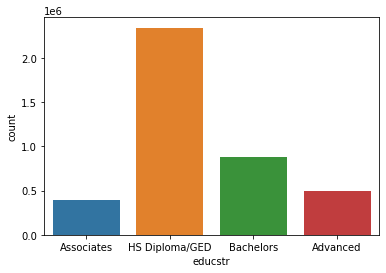

In [6]:
print("Number of people in each education category")
sns.countplot(x = df['educstr']);

Income quartile by education category


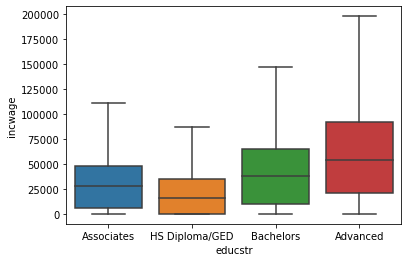

In [7]:
print("Income quartile by education category")
sns.boxplot(y = 'incwage', x = 'educstr', data = df,
            showfliers = False);

In [8]:
# Get Median Wages by year/education level
df_grouped = df.groupby(['year','educstr'], as_index = False)

grouped_med_wages = df_grouped[['incwage']].median()
grouped_med_wages = grouped_med_wages.pivot(index = 'year', columns = 'educstr', values = 'incwage')

# Get differences between Associates degree and bachelor's degree or HS diploma
grouped_med_wages['As_Ba'] = grouped_med_wages['Associates'] - grouped_med_wages['Bachelors']
grouped_med_wages['As_Hs'] = grouped_med_wages['Associates'] - grouped_med_wages['HS Diploma/GED']

print("Median wage by year/education level")
display(grouped_med_wages)

Median wage by year/education level


educstr,Advanced,Associates,Bachelors,HS Diploma/GED,As_Ba,As_Hs
year,,,,,,
2000,42700.0,25000.0,31500.0,16500.0,-6500.0,8500.0
2001,45000.0,25000.0,32000.0,16700.0,-7000.0,8300.0
2002,45000.0,26000.0,33000.0,16800.0,-7000.0,9200.0
2003,47200.0,26000.0,33000.0,16000.0,-7000.0,10000.0
2004,48000.0,26000.0,34000.0,16000.0,-8000.0,10000.0
2005,48800.0,26000.0,35000.0,16000.0,-9000.0,10000.0
2006,50000.0,27900.0,36000.0,17000.0,-8100.0,10900.0
2007,52000.0,28500.0,37700.0,17500.0,-9200.0,11000.0
2008,54000.0,29500.0,38200.0,18000.0,-8700.0,11500.0


In [9]:
#Education by gender
df_grouped_gender = df.groupby(['year','educstr'], as_index = False)[["sex"]].mean().round(2)
print("%Female") #NOTE FEMALE 1 ,MALE 0
df_grouped_gender.pivot(index = 'year', columns = 'educstr', values = 'sex')

%Female


educstr,Advanced,Associates,Bachelors,HS Diploma/GED
year,,,,
2000,0.48,0.56,0.52,0.53
2001,0.48,0.56,0.52,0.52
2002,0.49,0.57,0.52,0.52
2003,0.49,0.57,0.53,0.52
2004,0.50,0.57,0.53,0.52
2005,0.51,0.57,0.53,0.52
2006,0.51,0.57,0.53,0.52
2007,0.52,0.57,0.53,0.52
2008,0.52,0.58,0.53,0.52


In [10]:
print("%Male")
1-df_grouped_gender.pivot(index = 'year', columns = 'educstr', values = 'sex')

%Male


educstr,Advanced,Associates,Bachelors,HS Diploma/GED
year,,,,
2000,0.52,0.44,0.48,0.47
2001,0.52,0.44,0.48,0.48
2002,0.51,0.43,0.48,0.48
2003,0.51,0.43,0.47,0.48
2004,0.50,0.43,0.47,0.48
2005,0.49,0.43,0.47,0.48
2006,0.49,0.43,0.47,0.48
2007,0.48,0.43,0.47,0.48
2008,0.48,0.42,0.47,0.48


Median Wage Difference between Associates and Bachelors


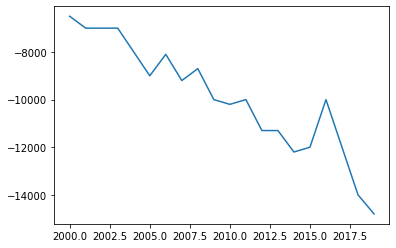

In [11]:
print("Median Wage Difference between Associates and Bachelors")
plt.plot(grouped_med_wages['As_Ba']);

Median Wage Difference between Associates and High School


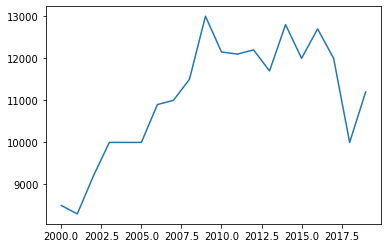

In [12]:
print("Median Wage Difference between Associates and High School")
plt.plot(grouped_med_wages['As_Hs']);

Interesting note: The wage premium for an associates degree was steadily increasing until the Global Financial Crisis, where it froze/declined.

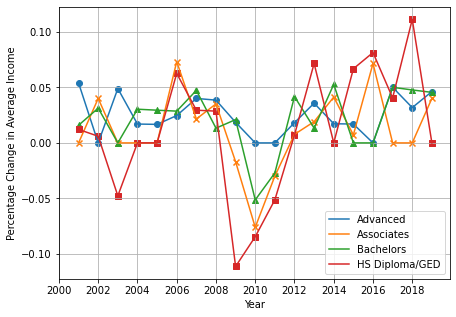

In [13]:
#Some additional plot by num
marker=["o","x","^","s"]
plt.figure(figsize=(7,5))
for i,j in enumerate(grouped_med_wages.columns[0:4]):
    plt.scatter(grouped_med_wages.index,grouped_med_wages[j].pct_change(),marker=marker[i])
    plt.plot(grouped_med_wages.index,grouped_med_wages[j].pct_change(),label=j)
plt.xticks(grouped_med_wages.index[0::2])
plt.legend(loc='lower right')
plt.xlabel("Year")
plt.ylabel("Percentage Change in Average Income")
plt.grid()
plt.show()

The GFC didn't affect people with advanced degrees at all.

# Ratio of people getting each degree over time

In [14]:
grouped_yreduc_count = df_grouped.size()
grouped_year_count = grouped_yreduc_count.groupby(['year'], as_index = False).sum()

grouped_yreduc_ratio = grouped_yreduc_count.merge(grouped_year_count, 
                               how = 'left', on = 'year')
grouped_yreduc_ratio['ratio'] = grouped_yreduc_ratio['size_x']/grouped_yreduc_ratio['size_y']
grouped_yreduc_ratio.drop(columns = ['size_x','size_y'], inplace = True)

Education Ratio by Year


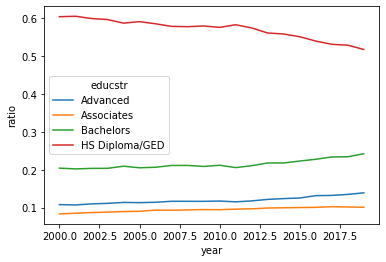

In [15]:
print("Education Ratio by Year")
sns.lineplot(x = 'year', y = 'ratio', hue = 'educstr', 
             data = grouped_yreduc_ratio);

Education Ratio by Year - AS and BA only


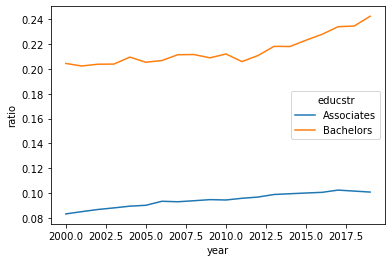

In [16]:
print("Education Ratio by Year - AS and BA only")
sns.lineplot(x = 'year', y = 'ratio', hue = 'educstr', 
             data = grouped_yreduc_ratio[ (grouped_yreduc_ratio['educstr'] == 'Associates')|
                                          (grouped_yreduc_ratio['educstr'] == 'Bachelors')]);

After the GFC, ratio of Bachelor's degree increases more dramatically, while ratio of Associates degrees rises at the same rate.

Education Ratio by Year - AS and HS only


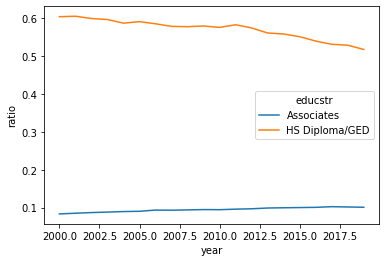

In [17]:
print("Education Ratio by Year - AS and HS only")
sns.lineplot(x = 'year', y = 'ratio', hue = 'educstr', 
             data = grouped_yreduc_ratio[ (grouped_yreduc_ratio['educstr'] == 'Associates')|
                                          (grouped_yreduc_ratio['educstr'] == 'HS Diploma/GED')]);

# Regression

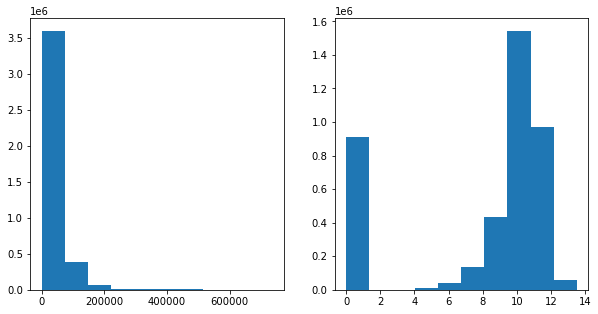

In [18]:
#WAGE VS LOG(WAGE)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(df.incwage)
ax[1].hist(np.log(df["incwage"].replace(0,1)))
plt.show()

#Log wage seems to be normally distributed

In [19]:
#Mean income by employment status
df.groupby("empstat")["incwage"].mean()

empstat
1    45973.010080
2    11249.810082
3     3696.644749
Name: incwage, dtype: float64

In [20]:
#% of people with zero income by employmeny status
df["no_wage"] = (df["incwage"]==0)
(df.groupby("empstat")["no_wage"].sum()/df.groupby("empstat")["empstat"].count())*100

empstat
1     5.525625
2    40.198032
3    79.475582
dtype: float64

In [21]:
#Models

#1 Basic y~x
#2 demographic control 
#### family inc and family stuff ---> size = NAN, and family inc is correlated with income for sure :()
#3 Time and time trend
#4 geo level control 
#5 full control

#Log_wage, replace 0 wage with 1 to avoid log(0)
y = np.log(df["incwage"].replace(0,1))
X = pd.get_dummies(df["educstr"]).drop("HS Diploma/GED",axis=1)

In [22]:
#Controls for individual factor
controls1 = ["race","age","sex","empstat","citizen","famsize"]
c1 = pd.get_dummies(df[controls1],columns=["race","empstat","citizen"],drop_first=True)

In [23]:
#Time Trend
df["time_trend"] = df["year"] - min(df.year)      #t
df["time_trend_squared"] = df["time_trend"]**2  #t^2

t = df[["time_trend", "time_trend_squared"]]

In [24]:
# Controls for family
# 90% missing values for parent's income. Can't use this


In [25]:
# Note about geo-level control: Not sure what to use, There's too many locations. Maybe need a proxy like local median wage
# Controls for location (state only for simplicity LOL)
c2 = pd.get_dummies(df["statefip"],drop_first=True)

# Note2: I have to rename the state dummy variables so that it works with stargazer package
c2 = c2.add_prefix('statefip_')
display(c2.columns)

Index(['statefip_2', 'statefip_4', 'statefip_5', 'statefip_6', 'statefip_8',
       'statefip_9', 'statefip_10', 'statefip_11', 'statefip_12',
       'statefip_13', 'statefip_15', 'statefip_16', 'statefip_17',
       'statefip_18', 'statefip_19', 'statefip_20', 'statefip_21',
       'statefip_22', 'statefip_23', 'statefip_24', 'statefip_25',
       'statefip_26', 'statefip_27', 'statefip_28', 'statefip_29',
       'statefip_30', 'statefip_31', 'statefip_32', 'statefip_33',
       'statefip_34', 'statefip_35', 'statefip_36', 'statefip_37',
       'statefip_38', 'statefip_39', 'statefip_40', 'statefip_41',
       'statefip_42', 'statefip_44', 'statefip_45', 'statefip_46',
       'statefip_47', 'statefip_48', 'statefip_49', 'statefip_50',
       'statefip_51', 'statefip_53', 'statefip_54', 'statefip_55',
       'statefip_56'],
      dtype='object')

In [26]:
#Interaction Variable
c1_int = c1.drop(["age","sex","famsize"],axis=1).copy()
for col in c1_int.columns:
    c1_int.loc[:,col+"_sex"] = c1_int[col]*c1["sex"]
    c1_int.drop(col,axis=1,inplace=True)
display(c1_int.columns)

Index(['race_2_sex', 'race_3_sex', 'race_4_sex', 'race_5_sex', 'race_6_sex',
       'race_7_sex', 'race_8_sex', 'race_9_sex', 'empstat_2_sex',
       'empstat_3_sex', 'citizen_1_sex', 'citizen_2_sex', 'citizen_3_sex'],
      dtype='object')

In [27]:
import statsmodels.api as sm
from stargazer.stargazer import Stargazer #nice tables with statsmodels

In [28]:
models = [
    sm.OLS(y,sm.add_constant(X)).fit(),
    sm.OLS(y,sm.add_constant(pd.concat([X, c1], axis=1))).fit(),
    sm.OLS(y,sm.add_constant(pd.concat([X, c1, t], axis=1))).fit(),
    sm.OLS(y,sm.add_constant(pd.concat([X, c1, t, c2], axis=1))).fit(),
    sm.OLS(y,sm.add_constant(pd.concat([X, c1, t, c2,c1_int], axis=1))).fit()
]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [29]:
#Make a nice table so that we can easily jot the number into a nice table with Microsoft word
table = Stargazer(models)
table.title('Prototype Model, LOG-LINEAR')
table.covariate_order([*X.columns])
table

In [30]:
# Repeat of previous models, but only look at people with wages
subset = df[df["incwage"] > 0]

y = np.log(subset["incwage"])
X = pd.get_dummies(subset["educstr"]).drop("HS Diploma/GED",axis=1)

In [31]:
#Controls for subset
controls1 = ["race","age","sex","empstat","citizen","famsize"]
c1 = pd.get_dummies(subset[controls1],columns=["race","empstat","citizen"],drop_first=True)
                    

c2 = pd.get_dummies(subset["statefip"],drop_first=True)
c2 = c2.add_prefix('statefip_')
                    
c1_int = c1.drop(["age","sex","famsize"],axis=1).copy()
for col in c1_int.columns:
    c1_int.loc[:,col+"_sex"] = c1_int[col]*c1["sex"]
    c1_int.drop(col,axis=1,inplace=True)

In [32]:
#Time Trend
subset["time_trend"] = subset["year"] - min(subset.year)      #t
subset["time_trend_squared"] = subset["time_trend"]**2  #t^2

t = subset[["time_trend", "time_trend_squared"]]

C:\Users\prach\AppData\Local\Temp/ipykernel_11160/4291111595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["time_trend"] = subset["year"] - min(subset.year)      #t
C:\Users\prach\AppData\Local\Temp/ipykernel_11160/4291111595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["time_trend_squared"] = subset["time_trend"]**2  #t^2


In [33]:
# Fit models
ols1 = sm.OLS(y,sm.add_constant(X)).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
ols2 = sm.OLS(y,sm.add_constant(pd.concat([X, c1], axis=1))).fit()

In [35]:
ols3 = sm.OLS(y,sm.add_constant(pd.concat([X, c1, c2], axis=1))).fit()

In [36]:
ols4 = sm.OLS(y,sm.add_constant(pd.concat([X, c1, c2, t], axis=1))).fit()

In [37]:
ols5 = sm.OLS(y,sm.add_constant(pd.concat([X, c1, c2, t, c1_int], axis=1))).fit()

In [38]:
models = [ols1,ols2,ols3,ols4,ols5]

table = Stargazer(models)
table.title('Prototype Model, Data subset: incwage > 0, LOG-LINEAR')
table.covariate_order([*X.columns])
table

Subsetting for people with income, the degree effect is lowered.

As seen in the Observations section of the table, 800k out of 4mil were dropped because of no income. This is an important step and side effect to mention.